In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import PlaceCellAnalysis as pc
import pickle

os.sys.path.append('../')
import utilities as u
import preprocessing as pp
import behavior as b
import logistic_regression as lr
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5']
morph_familiar = ['4222153.2','4222154.1','4222153.1']

In [61]:
def LLR_list_maker(mlist):
    LLR_list = []
    morphs = np.linspace(0,1,num=6)[1:]
    for mouse in mlist: 
        df_mouse = df[df['MouseName'].str.match(mouse)]
        
        dirbase = os.path.join("G:\\My Drive\\Figures\\TwoTower\\LogReg_smooth",mouse)
        for mat_ind,sess_ind in enumerate(np.arange(5,df_mouse.shape[0])):
            print("session ind",sess_ind)
            sess = df_mouse.iloc[sess_ind]
            
            fname = "%s\\%s_%d_Xhat.pkl" % (dirbase,sess['DateFolder'],sess['SessionNumber'])
            if os.path.isfile(fname):
                with open(fname,"rb") as f:
                    d = pickle.load(f)
                    Xhat=d['Xhat']
            
            
                VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
                trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


                effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
                effMorph+=.2
                effMorph/=1.4
#                 effMorph= (effMorph-np.amin(effMorph))/(np.amax(effMorph)-np.amin(effMorph))
                msort = np.argsort(effMorph)
#                 effMorph=effMorph[msort]
                effMorph_dig = np.digitize(effMorph,morphs,right=True)
               

                #
                half = int(Xhat.shape[1]/2)
                num,den = Xhat[:,:half].sum(axis=1),Xhat[:,half:].sum(axis=1)
                llr = np.log(num)-np.log(den)
                llr_trial_mat = u.make_pos_bin_trial_matrices(llr,VRDat.pos._values,VRDat['tstart']._values,VRDat['teleport']._values,mat_only=True,bin_size=10)
                print(llr_trial_mat.shape)
                llr_pos_avg = np.nanmean(llr_trial_mat,axis=1)
                #
                
                avgLLR_tmp = np.zeros([morphs.shape[0],])
                for morph_ind,morph_r in enumerate(range(np.amax(effMorph_dig)+1)):
                        
                    avgLLR_tmp[morph_ind]=np.nanmean(llr_pos_avg[effMorph_dig==morph_r])
                        
#                 f,ax = plt.subplots() 
#                 ax.plot(avgLLR_tmp)
                if mat_ind == 0:
                    avgLLR = np.zeros([avgLLR_tmp.shape[0],df_mouse.shape[0]-5])

                avgLLR[:,mat_ind]=avgLLR_tmp


        LLR_list.append(avgLLR)
        
    return LLR_list

In [63]:
def LLR_ravel_maker(mlist):
    LLR_list = []
    effMorph_list = []
#     morphs = np.linspace(0,1,num=6)[1:]
    for mouse in mlist: 
        df_mouse = df[df['MouseName'].str.match(mouse)]
        
        dirbase = os.path.join("G:\\My Drive\\Figures\\TwoTower\\LogReg_smooth",mouse)
        _llr = []
        _em = []
        for mat_ind,sess_ind in enumerate(np.arange(5,df_mouse.shape[0])):
            print("session ind",sess_ind)
            sess = df_mouse.iloc[sess_ind]
            
            fname = "%s\\%s_%d_Xhat.pkl" % (dirbase,sess['DateFolder'],sess['SessionNumber'])
            if os.path.isfile(fname):
                with open(fname,"rb") as f:
                    d = pickle.load(f)
                    Xhat=d['Xhat']
            
            
                VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
                trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


                effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
                effMorph+=.2
                effMorph/=1.4
                
                
                #
                half = int(Xhat.shape[1]/2)
                num,den = Xhat[:,:half].sum(axis=1),Xhat[:,half:].sum(axis=1)
                llr = np.log(num)-np.log(den)
                llr_trial_mat = u.make_pos_bin_trial_matrices(llr,VRDat.pos._values,VRDat['tstart']._values,VRDat['teleport']._values,mat_only=True,bin_size=10)
                print(llr_trial_mat.shape)
                _llr.extend(np.nanmean(llr_trial_mat,axis=1).tolist())
                _em.extend(effMorph.tolist())
                #
                


        LLR_list.append(_llr)
        effMorph_list.append(_em)
    return LLR_list,effMorph_list

In [64]:
LLR_rare = LLR_ravel_maker(morph_rare)
LLR_fam = LLR_ravel_maker(morph_familiar)

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


(120, 45)
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
frame diff 0
(120, 45)
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
frame diff 0
(120, 45)
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
frame diff 0
(120, 45)
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
(120, 45)
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
(120, 45)
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
(120, 45)
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
(120, 45)
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
(120, 45)
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
(120, 45)
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
(120, 45)
session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 2

In [65]:
def mean_mouse_plots(LLR_list_list,cmap_list):
    
    
    f,ax = plt.subplots(1,2,figsize=[10,5])
    for LLR_list,cmap in zip(LLR_list_list,cmap_list):
        cm = plt.cm.get_cmap(cmap)
        for mouse in range(len(LLR_list)):
            color = mouse/np.float(len(LLR_list))
            llr_tmp = LLR_list[mouse]
            llr_mean = llr_tmp.mean(axis=-1)
            llr_sem = sp.stats.sem(llr_tmp,axis=-1)

            minn,maxx = np.amin(llr_mean),np.amax(llr_mean)

            llr_n_mu  = (llr_mean-minn)/(maxx-minn)
            llr_n_sem = llr_sem/(maxx-minn)


            dm = 1/llr_tmp.shape[0]
            morphs = np.arange(dm-dm/2,1,dm)


            ax[0].fill_between(morphs,llr_mean+llr_sem,y2=llr_mean-llr_sem,color=cm(color),alpha=.5)
            ax[1].fill_between(morphs,llr_n_mu+llr_n_sem,y2=llr_n_mu-llr_n_sem,color=cm(color),alpha=.5)
        
    return f,ax

In [87]:
def mouse_plots(LLR_list,em_list,cmap='copper',fax = None):
    
    
   
    cm = plt.cm.get_cmap(cmap)
    mega_llr,mega_em = [],[]
    if fax is None:
        f = plt.figure()
        gs = gridspec.GridSpec(1,6)
        ax_scat = f.add_subplot(gs[:,:5])
        ax_hist= f.add_subplot(gs[:,-1])
    else:
        f,gs,ax_scat,ax_hist = fax[0],fax[1],fax[2],fax[3]
        
    
    for mouse,(llr_tmp,em_tmp) in enumerate(zip(LLR_list,em_list)):
        ax_scat.scatter(em_tmp,llr_tmp,color=cm(np.float(mouse/len(LLR_list))),s=8,alpha=.3)
        ax_hist.hist(llr_tmp,bins=20,density=True,color=cm(np.float(mouse/len(LLR_list))),alpha=.3,orientation="horizontal")
        
        mega_llr.extend(llr_tmp)
        mega_em.extend(em_tmp)
#     ax_hist
        
    return f,(ax_scat,ax_hist)

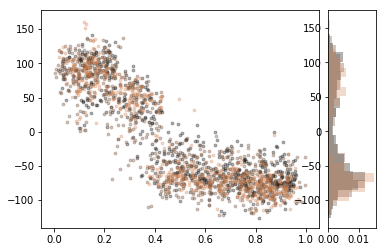

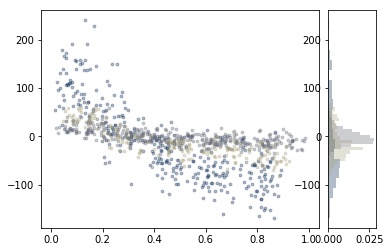

In [88]:
f_rare,ax_rare=mouse_plots(LLR_rare[0],LLR_rare[1])
f_fam,ax_fam = mouse_plots(LLR_fam[0],LLR_fam[1],cmap='cividis')

In [98]:
def bighist(LLR_list,em_list,bins= np.linspace(-200,200)):
    cnts = np.zeros(bins.shape[0]-1)
    for mouse,(llr_tmp,em_tmp) in enumerate(zip(LLR_list,em_list)):
        tmpcnt,trash = np.histogram(llr_tmp,bins)
        tmpcnt=tmpcnt/tmpcnt.sum()
        cnts+=tmpcnt
    cnts/=mouse
    return cnts

In [99]:
rare_hist = bighist(LLR_rare[0],LLR_rare[1])
fam_hist = bighist(LLR_fam[0],LLR_fam[1])

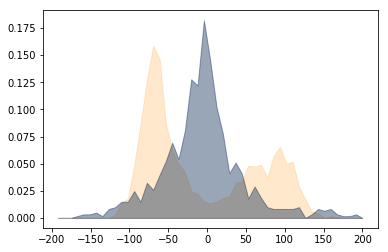

In [107]:
f,ax = plt.subplots()
ax.fill_between(np.linspace(-200,200)[1:],rare_hist,color=plt.cm.copper(1.),alpha=.4)
ax.fill_between(np.linspace(-200,200)[1:],fam_hist,color=plt.cm.cividis(0.),alpha=.4)